In [1]:
import numpy as np
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.preprocessing import sequence

%matplotlib inline

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from preprocess import load_from_directory, divide_to_train_and_test, one_hot
from confusion_matrix import print_confusion_matrix

In [3]:
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #use GPU with ID=0
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5 # maximun alloc gpu50% of MEM
config.gpu_options.allow_growth = True #allocate dynamically
sess = tf.Session(config = config)

In [4]:
%%time
file_texts, targets = load_from_directory("D:/svruchtel/DATA/USA_Small", 
                                         ["Airfare", "CarRental", "GeneralRetail", "Hotel", "Other", "Parking", "Restaurant",
                                         "Taxi", "Transport"],
                                         max_files_in_one_category=200)

PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Airfare\0000079.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Airfare\0000116.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Airfare\0000142.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Airfare\0000182.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\GeneralRetail\0000147.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\GeneralRetail\0000150.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000081.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000093.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000094.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000095.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000118.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000119.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000120.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000121.txt
PROBLEM WITH FILE D:/svruchtel/DATA/USA_Small\Hotel\0000122.txt
PROBLEM WITH FIL

In [5]:
X = []
for text in file_texts:
    #X.append([word for word in text.strip().split(" ") if word != ""])
    #X.append([word for word in re.findall(r"[\w']+|:", text) if word != "" or word != ":"])
    X.append([word for word in text.strip().replace(":", " ").replace(".", " ").replace("!", " ").replace("?", " ").replace(",", " ").replace(";", " ").split(" ") if word != "" ])
    
# lets make each text no longer than 200 words
X = sequence.pad_sequences(X, maxlen=200, dtype='str', padding='post')

In [6]:
print(X[1])

['DellaNeve' 'Nick' 'From' 'Sent' 'To' 'Cc' 'Subject' 'For' 'the'
 'largest' 'items' 'Jarvis' 'Claire' 'Monday' 'July' '17' '2017' '4' '42'
 'PM' 'DellaNeve' 'Nick' 'Wise' 'Michael' 'J' 'Suggested' 'budget' '-'
 'Total' '4' 'transatlantic' 'flights' '@' '$6-8k' 'per' 'flight'
 '(Business' 'Class' 'fare)' 'to' 'be' 'used' 'however' 'selected' 'i' 'e'
 'donâ€™t' 'feel' 'obliged' 'to' 'use' 'for' 'fly' 'backs' 'or' 'class'
 'constrained' 'if' 'other' 'trips' 'are' 'preferable' '-' 'Accommodation'
 '@' '$3500' 'a' 'month' 'Food' 'etc' 'to' 'be' 'expensed' 'per' 'our'
 'normal' 'policy' 'Let' 'me' 'know' 'if' 'you' 'have' 'any' 'questions'
 'Best' 'Regards' 'Claire' 'Jarvis' 'Manager' 'A' 'T' 'Kearney' 'Inc' '7'
 'Times' 'Square' 'New' 'York' 'New' 'York' '10036' 'United' 'States' '+1'
 '212' '705' '1508' 'Direct' '+1' '6463062194' 'Mobile' '1' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0

In [7]:
X_train, targets_train, X_test, targets_test = divide_to_train_and_test(X, targets, num_categories=9)

# one-hot encoding for targets
y_train = one_hot(targets_train, classes_count=9)
y_test = one_hot(targets_test, classes_count=9)

In [8]:
#let's try to write another version of "load_embeddins"

def load_embeddings(emb_path, max_embeddings_count=100000):
    emb_word_id_to_vector = {}
    word_to_id = {}
    current_word_id = 0
    with open(emb_path, 'r', encoding='utf-8') as f:
        for line in f:
            if current_word_id <= max_embeddings_count:
                line_split = line.strip().split(" ")
                word = line_split[0]
                word_emb = np.array(line_split[1:], dtype=float)
            
                if word_emb.shape != (300,):
                    print("ERROR! Shape is", word_emb.shape, word)
                    continue
            
                word_to_id[word] = current_word_id
                emb_word_id_to_vector[current_word_id] = word_emb
                current_word_id += 1
            else:
                break
            
    return emb_word_id_to_vector, word_to_id

In [9]:
%%time
emb_word_id_to_vector, word_to_id = load_embeddings("D:/svruchtel/EMBEDDINGS/glove.840B.300d/glove.840B.300d.txt", 
                                    max_embeddings_count=300000)

ERROR! Shape is (299,) 0.20785
ERROR! Shape is (299,) 0.39511
Wall time: 1min 15s


In [10]:
# now I should change each word to its embedding

def change_words_to_their_embeddings(X, embedding_word_id_to_vector, word_to_id):
    X_emb = []
    for text in X:
        embedded_text = []
        for word in text:
            if word in word_to_id:
                embedded_text.append(embedding_word_id_to_vector[word_to_id[word]])
            elif word.lower() in word_to_id:
                embedded_text.append(embedding_word_id_to_vector[word_to_id[word.lower()]])
            else:
                embedded_text.append(embedding_word_id_to_vector[word_to_id["0.0"]])
                print("There is no embedding for word", word)
        X_emb.append(np.array(embedded_text))
    return np.array(X_emb)

In [11]:
X_train

array([['Receipt', 'for', 'Beirut', ..., '0.0', '0.0', '0.0'],
       ['DellaNeve', 'Nick', 'From', ..., '0.0', '0.0', '0.0'],
       ['Date', 'From', 'Date', ..., '9005/inbox/portal/inbox/mydocume',
        'jsf#', '1/1'],
       ...,
       ['most', 'Acela', 'Express', ..., '1-', '800-523-6590', '3'],
       ['STATES', 'YOU', 'MAY', ..., 'FAA',
        'GOV/ABOUT/INITIATIVES/HAZMAT', 'SAFETY/'],
       ['STATES', 'YOU', 'MAY', ..., 'FAA',
        'GOV/ABOUT/INITIATIVES/HAZMAT', 'SAFETY/']], dtype='<U32')

In [12]:
X_train_emb = change_words_to_their_embeddings(X_train, emb_word_id_to_vector, word_to_id)
X_test_emb = change_words_to_their_embeddings(X_test, emb_word_id_to_vector, word_to_id)

There is no embedding for word 7285684220348
There is no embedding for word â€¢
There is no embedding for word (CVG)
There is no embedding for word (BEY)
There is no embedding for word 8/10/2017
There is no embedding for word 8/28/2017
There is no embedding for word â€¢
There is no embedding for word BAHIGE
There is no embedding for word ELRAYES
There is no embedding for word 0578643753685
There is no embedding for word $2
There is no embedding for word $1
There is no embedding for word $624
There is no embedding for word $10
There is no embedding for word $2
There is no embedding for word $2
There is no embedding for word [AmericanExpress
There is no embedding for word 2002]
There is no embedding for word DellaNeve
There is no embedding for word DellaNeve
There is no embedding for word $6-8k
There is no embedding for word (Business
There is no embedding for word fare)
There is no embedding for word donâ€™t
There is no embedding for word $3500
There is no embedding for word 6463062194


In [13]:
print(X_train_emb.shape)
print(y_train.shape)
print(X_test_emb.shape)
print(y_test.shape)

(877, 200, 300)
(877, 9)
(102, 200, 300)
(102, 9)


In [14]:
%%time
# create the model
max_text_length = 200
categories_count = 9

model = Sequential()
model.add(LSTM(100, input_shape=X_train_emb[0].shape))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_train_emb, y_train, validation_data=(X_test_emb, y_test), epochs=200, batch_size=10, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test_emb, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 909       
Total params: 161,309
Trainable params: 161,309
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 104s 119ms/step - loss: 1.6461 - acc: 0.4014 - val_loss: 1.6002 - val_acc: 0.4804
Epoch 2/200
877/877 [==============================] - 102s 116ms/step - loss: 1.3293 - acc: 0.5268 - val_loss: 1.5072 - val_acc: 0.5196
Epoch 3/200
877/877 [==============================] - 97s 111ms/step - loss: 1.0926 - acc: 0.6522 - val_loss: 1.3720 - val_acc: 0.6176
Epoch 4/200
877/877 [==============================] - 94s 107ms/step -

In [ ]:
# write results into file then

In [15]:
info_df = pd.DataFrame(columns=['architecture_str', 'dataset_name','embeddings_type', 'embeddings_name',
                                'train_size', 'test_size', 'batch_size',
                                'best_train_acc', 'last_train_acc', 'idx_best_train_acc',
                                'best_train_loss', 'last_train_loss', 'idx_best_train_loss',
                                'best_val_acc', 'last_val_acc', 'idx_best_val_acc',
                                'best_val_loss', 'last_val_loss', 'idx_best_val_loss',
                                'epochs_count', 'result_acc'])

In [16]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'LSTM(100) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'word', 'embeddings_name':'glove.840B.300d',
       'train_size':X_train_emb.shape[0], 'test_size':X_test_emb.shape[0], 'batch_size':10,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[163   0   0   0  16   0   0   0   1]
 [  2  49   0   0   5   0   1   0   0]
 [  0   0  27   0  16   0   1   1   0]
 [  0   0   0 180   0   0   0   0   0]
 [  0   0   0   1 179   0   0   0   0]
 [  0   0   0   0   2   0   0   1   0]
 [  0   0   0   0  18   0  37   0   0]
 [  0   0   0   0  31   0   0  98   0]
 [  4   1   0   0   7   0   0   2  34]]
Normalized confusion matrix
[[0.90555556 0.         0.         0.         0.08888889 0.
  0.         0.         0.00555556]
 [0.03508772 0.85964912 0.         0.         0.0877193  0.
  0.01754386 0.         0.        ]
 [0.         0.         0.6        0.         0.35555556 0.
  0.02222222 0.02222222 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.00555556 0.99444444 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.66666667 0.
  0.         0.33

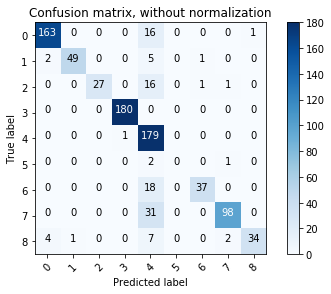

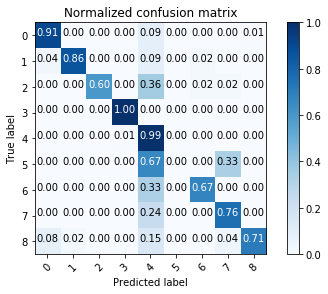

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[18  0  0  0  1  0  0  1  0]
 [ 0  1  0  2  1  0  0  0  3]
 [ 1  0  0  1  2  0  0  2  0]
 [ 1  0  0 19  0  0  0  0  0]
 [ 0  0  0  0 19  0  0  1  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  3  0  2  2  0]
 [ 0  0  0  0  5  0  1  9  0]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.9        0.         0.         0.         0.05       0.
  0.         0.05       0.        ]
 [0.         0.14285714 0.         0.28571429 0.14285714 0.
  0.         0.         0.42857143]
 [0.16666667 0.         0.         0.16666667 0.33333333 0.
  0.         0.33333333 0.        ]
 [0.05       0.         0.         0.95       0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.95       0.
  0.         0.05       0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.42857143 0.
  0

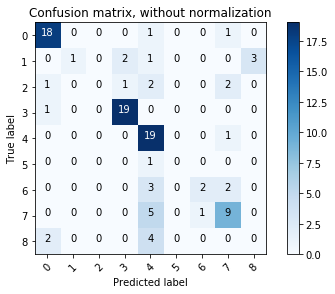

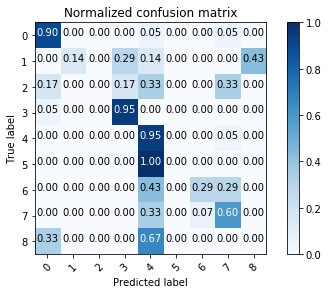

In [17]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train_emb)
print_confusion_matrix(X_train_emb, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test_emb)
print_confusion_matrix(X_test_emb, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [18]:
%%time
# Lets try one another architecture

# create the model
max_text_length = 200
categories_count = 9

model = Sequential()
model.add(LSTM(100, input_shape=X_train_emb[0].shape))
model.add(Dropout(0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_train_emb, y_train, validation_data=(X_test_emb, y_test), epochs=200, batch_size=10, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test_emb, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 909       
Total params: 161,309
Trainable params: 161,309
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 98s 111ms/step - loss: 1.6592 - acc: 0.3603 - val_loss: 1.5750 - val_acc: 0.4804
Epoch 2/200
877/877 [==============================] - 94s 107ms/step - loss: 1.3712 - acc: 0.5063 - val_loss: 1.4658 - val_acc: 0.5000
Epoch 3/200
877/877 [==============================] - 95s 109ms/step - loss:

In [19]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'LSTM(100) Dropout(0.2) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'word', 'embeddings_name':'glove.840B.300d',
       'train_size':X_train_emb.shape[0], 'test_size':X_test_emb.shape[0], 'batch_size':10,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[165   0   0   0   3   0   0  11   1]
 [  2  49   0   0   0   0   1   5   0]
 [  0   0  32   0   2   0   0  11   0]
 [  0   0   0 179   1   0   0   0   0]
 [  1   0   0   1 147   0   0  30   1]
 [  0   0   0   1   1   0   0   1   0]
 [  0   0   0   0   1   0  38  16   0]
 [  0   0   0   0   1   0   0 127   1]
 [  3   1   0   0   0   0   0   5  39]]
Normalized confusion matrix
[[0.91666667 0.         0.         0.         0.01666667 0.
  0.         0.06111111 0.00555556]
 [0.03508772 0.85964912 0.         0.         0.         0.
  0.01754386 0.0877193  0.        ]
 [0.         0.         0.71111111 0.         0.04444444 0.
  0.         0.24444444 0.        ]
 [0.         0.         0.         0.99444444 0.00555556 0.
  0.         0.         0.        ]
 [0.00555556 0.         0.         0.00555556 0.81666667 0.
  0.         0.16666667 0.00555556]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.         0.33

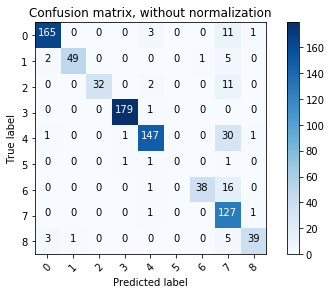

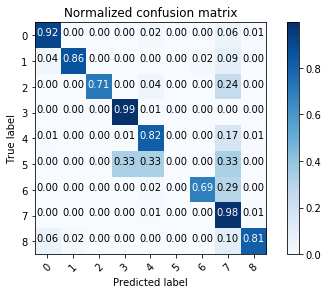

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[19  0  0  0  0  0  0  1  0]
 [ 0  1  0  0  2  0  0  1  3]
 [ 1  0  0  1  0  0  1  3  0]
 [ 0  0  0 20  0  0  0  0  0]
 [ 2  0  1  0  4  0  0 13  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  2  3  1]
 [ 0  0  1  0  0  0  1 11  2]
 [ 2  0  0  0  0  0  0  4  0]]
Normalized confusion matrix
[[0.95       0.         0.         0.         0.         0.
  0.         0.05       0.        ]
 [0.         0.14285714 0.         0.         0.28571429 0.
  0.         0.14285714 0.42857143]
 [0.16666667 0.         0.         0.16666667 0.         0.
  0.16666667 0.5        0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.1        0.         0.05       0.         0.2        0.
  0.         0.65       0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.14285714 0.
  0

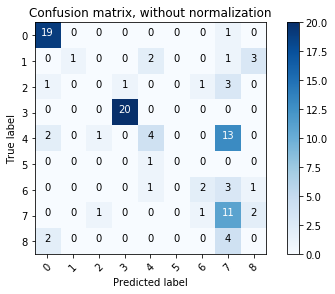

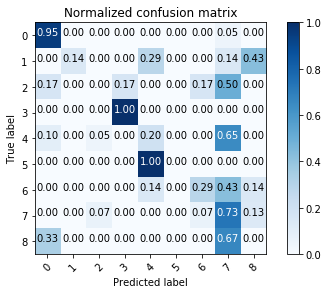

In [20]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train_emb)
print_confusion_matrix(X_train_emb, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test_emb)
print_confusion_matrix(X_test_emb, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [22]:
%%time
# and another

# create the model
max_text_length = 200
categories_count = 9

model = Sequential()
model.add(LSTM(100, input_shape=X_train_emb[0].shape, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_train_emb, y_train, validation_data=(X_test_emb, y_test), epochs=200, batch_size=10, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test_emb, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 161,309
Trainable params: 161,309
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 108s 123ms/step - loss: 1.6786 - acc: 0.3945 - val_loss: 1.5979 - val_acc: 0.4706
Epoch 2/200
877/877 [==============================] - 105s 120ms/step - loss: 1.3369 - acc: 0.5314 - val_loss: 1.4110 - val_acc: 0.5294
Epoch 3/200
877/877 [==============================] - 102s 117ms/step - loss: 1.0612 - acc: 0.6670 - val_loss: 1.3796 - val_acc: 0.6569
Epoch 4/200
877/877 [==============================] - 98s 111ms/step 

In [23]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'LSTM(100, recurrent_dropout=0.2) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'word', 'embeddings_name':'glove.840B.300d',
       'train_size':X_train_emb.shape[0], 'test_size':X_test_emb.shape[0], 'batch_size':10,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[164   0   0   0   4   0   0  11   1]
 [  2  50   0   0   0   0   0   5   0]
 [  0   0  32   0   1   0   0  12   0]
 [  0   0   0 180   0   0   0   0   0]
 [  0   0   0   1 149   0   0  30   0]
 [  0   0   0   1   1   0   0   1   0]
 [  0   0   0   0   1   0  38  16   0]
 [  0   0   0   0   1   0   0 128   0]
 [  4   1   0   0   0   0   0   6  37]]
Normalized confusion matrix
[[0.91111111 0.         0.         0.         0.02222222 0.
  0.         0.06111111 0.00555556]
 [0.03508772 0.87719298 0.         0.         0.         0.
  0.         0.0877193  0.        ]
 [0.         0.         0.71111111 0.         0.02222222 0.
  0.         0.26666667 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.00555556 0.82777778 0.
  0.         0.16666667 0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.         0.33

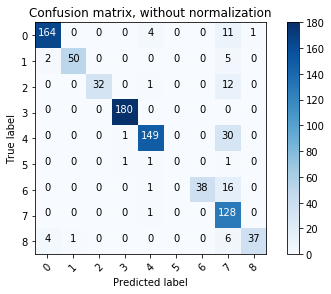

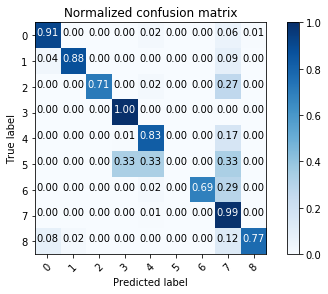

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[19  0  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  2  1  3]
 [ 1  0  0  0  1  0  1  3  0]
 [ 0  0  0 20  0  0  0  0  0]
 [ 2  0  0  0  3  0  1 14  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  1  0  3  3  0]
 [ 0  0  1  0  0  0  1 13  0]
 [ 2  0  0  0  0  0  0  4  0]]
Normalized confusion matrix
[[0.95       0.         0.         0.         0.         0.
  0.         0.05       0.        ]
 [0.         0.14285714 0.         0.         0.         0.
  0.28571429 0.14285714 0.42857143]
 [0.16666667 0.         0.         0.         0.16666667 0.
  0.16666667 0.5        0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.1        0.         0.         0.         0.15       0.
  0.05       0.7        0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.14285714 0.
  0

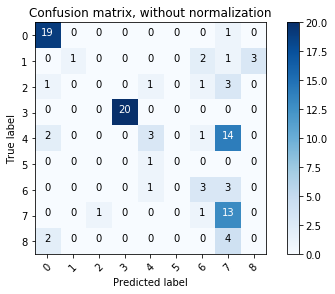

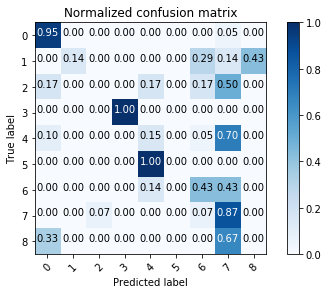

In [24]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train_emb)
print_confusion_matrix(X_train_emb, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test_emb)
print_confusion_matrix(X_test_emb, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [36]:
%%time
# and two LSTM's

# create the model
max_text_length = 200
categories_count = 9

model = Sequential()
model.add(LSTM(100, input_shape=X_train_emb[0].shape, recurrent_dropout=0.4, return_sequences=True))
model.add(LSTM(200, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto')
history = model.fit(X_train_emb, y_train, validation_data=(X_test_emb, y_test), epochs=200, batch_size=10, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test_emb, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 200, 100)          160400    
_________________________________________________________________
lstm_24 (LSTM)               (None, 200)               240800    
_________________________________________________________________
dense_7 (Dense)              (None, 9)                 1809      
Total params: 403,009
Trainable params: 403,009
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 215s 246ms/step - loss: 1.6744 - acc: 0.3797 - val_loss: 1.6420 - val_acc: 0.4216
Epoch 2/200
877/877 [==============================] - 201s 229ms/step - loss: 1.4352 - acc: 0.4812 - val_loss: 1.6438 - val_acc: 0.5686
Epoch 3/200
877/877 [==============================] - 204s 233ms/step - lo

In [37]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'LSTM(100, recurrent_dropout=0.4, return_sequences=True) LSTM(200, dropout=0.2, recurrent_dropout=0.2) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'word', 'embeddings_name':'glove.840B.300d',
       'train_size':X_train_emb.shape[0], 'test_size':X_test_emb.shape[0], 'batch_size':10,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[161   1   0   0   4   0   0  11   3]
 [  0  49   0   1   0   0   2   5   0]
 [  0   0  29   0   1   0   1  14   0]
 [  0   0   0 180   0   0   0   0   0]
 [  1   0   1   2 144   0   0  32   0]
 [  0   0   0   1   0   0   0   2   0]
 [  0   0   1   0   1   0  36  17   0]
 [  0   0   1   1   0   0   0 127   0]
 [  7   1   0   0   1   0   1   6  32]]
Normalized confusion matrix
[[0.89444444 0.00555556 0.         0.         0.02222222 0.
  0.         0.06111111 0.01666667]
 [0.         0.85964912 0.         0.01754386 0.         0.
  0.03508772 0.0877193  0.        ]
 [0.         0.         0.64444444 0.         0.02222222 0.
  0.02222222 0.31111111 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.00555556 0.         0.00555556 0.01111111 0.8        0.
  0.         0.17777778 0.        ]
 [0.         0.         0.         0.33333333 0.         0.
  0.         0.66

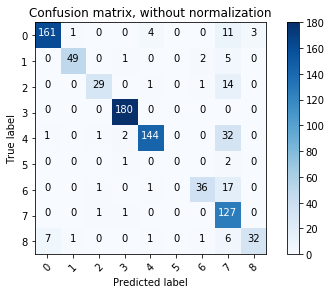

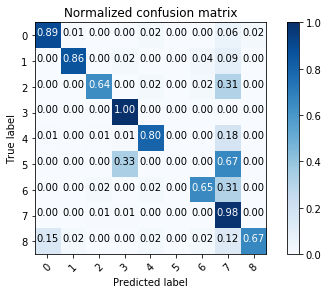

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[19  0  0  0  0  0  0  1  0]
 [ 4  1  0  1  0  0  0  1  0]
 [ 0  0  1  1  1  0  0  3  0]
 [ 1  0  0 19  0  0  0  0  0]
 [ 1  0  0  0  4  0  2 13  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  1  0  2  4  0]
 [ 0  0  1  1  0  0  0 12  1]
 [ 2  0  0  0  0  0  0  4  0]]
Normalized confusion matrix
[[0.95       0.         0.         0.         0.         0.
  0.         0.05       0.        ]
 [0.57142857 0.14285714 0.         0.14285714 0.         0.
  0.         0.14285714 0.        ]
 [0.         0.         0.16666667 0.16666667 0.16666667 0.
  0.         0.5        0.        ]
 [0.05       0.         0.         0.95       0.         0.
  0.         0.         0.        ]
 [0.05       0.         0.         0.         0.2        0.
  0.1        0.65       0.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.        ]
 [0.         0.         0.         0.         0.14285714 0.
  0

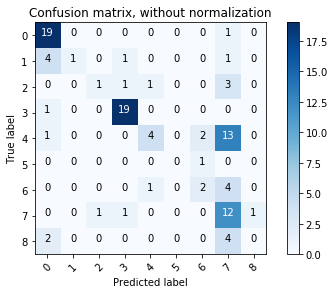

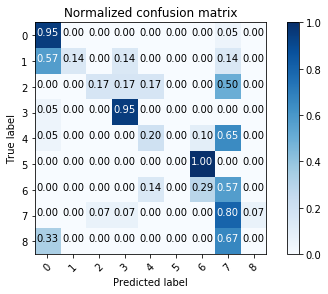

In [38]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train_emb)
print_confusion_matrix(X_train_emb, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test_emb)
print_confusion_matrix(X_test_emb, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [39]:
%%time
# and also with 1d-convolutional layer

# create the model
max_text_length = 200
categories_count = 9

model = Sequential()
model.add(Conv1D(input_shape=X_train_emb[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_train_emb, y_train, validation_data=(X_test_emb, y_test), epochs=200, batch_size=10, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test_emb, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 200, 32)           28832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_8 (Dense)              (None, 9)                 909       
Total params: 82,941
Trainable params: 82,941
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 68s 78ms/step - loss: 1.6476 - acc: 0.3774 - val_loss: 1.6228 - val_acc: 0.4608
Epoch 2/200
877/877 [==============================] - 65s 74ms/step - loss: 1.4135 

In [40]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'Conv1D(filters=32, kernel_size=3, padding="same", activation="relu") MaxPooling1D(pool_size=2) LSTM(100) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'word', 'embeddings_name':'glove.840B.300d',
       'train_size':X_train_emb.shape[0], 'test_size':X_test_emb.shape[0], 'batch_size':10,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[152   1   0   0  19   0   0   4   4]
 [  0  51   0   0   6   0   0   0   0]
 [  0   0  25   0  17   0   2   1   0]
 [  0   0   0 179   1   0   0   0   0]
 [  0   0   0   3 175   0   0   2   0]
 [  0   0   0   1   1   0   0   1   0]
 [  0   0   4   0  19   0  31   1   0]
 [  0   0   0   0  31   0   0  98   0]
 [  2   1   0   0   7   0   0   0  38]]
Normalized confusion matrix
[[0.84444444 0.00555556 0.         0.         0.10555556 0.
  0.         0.02222222 0.02222222]
 [0.         0.89473684 0.         0.         0.10526316 0.
  0.         0.         0.        ]
 [0.         0.         0.55555556 0.         0.37777778 0.
  0.04444444 0.02222222 0.        ]
 [0.         0.         0.         0.99444444 0.00555556 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.01666667 0.97222222 0.
  0.         0.01111111 0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.         0.33

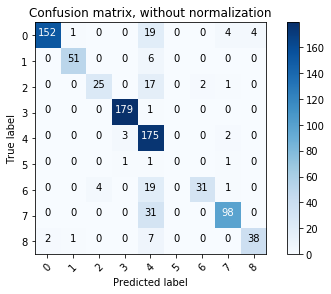

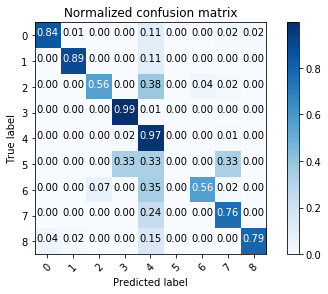

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[19  0  0  0  1  0  0  0  0]
 [ 0  1  0  0  3  0  0  0  3]
 [ 0  0  0  0  4  0  0  1  1]
 [ 0  0  0 20  0  0  0  0  0]
 [ 0  0  2  0 16  0  0  1  1]
 [ 0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0  3  0  3  1  0]
 [ 0  0  1  0  5  0  0  9  0]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.95       0.         0.         0.         0.05       0.
  0.         0.         0.        ]
 [0.         0.14285714 0.         0.         0.42857143 0.
  0.         0.         0.42857143]
 [0.         0.         0.         0.         0.66666667 0.
  0.         0.16666667 0.16666667]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.1        0.         0.8        0.
  0.         0.05       0.05      ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.42857143 0.
  0

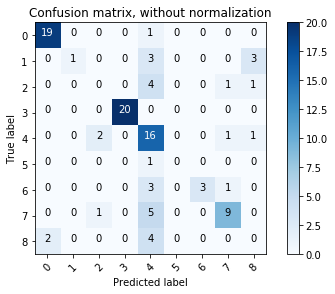

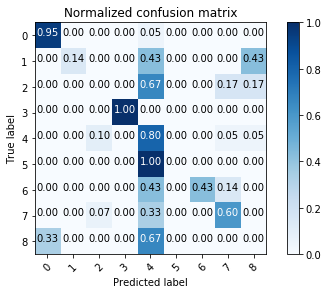

In [41]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train_emb)
print_confusion_matrix(X_train_emb, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test_emb)
print_confusion_matrix(X_test_emb, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)


In [42]:
%%time

# create the model
max_text_length = 200
categories_count = 9

model = Sequential()
model.add(Conv1D(input_shape=X_train_emb[0].shape, filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, recurrent_dropout=0.2))
model.add(Dense(9, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
history = model.fit(X_train_emb, y_train, validation_data=(X_test_emb, y_test), epochs=200, batch_size=10, callbacks=[callback])

# Final evaluation of the model
test_scores = model.evaluate(X_test_emb, y_test, verbose=0)
print("Accuracy: %.2f" % (test_scores[1]))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 200, 32)           28832     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 32)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_9 (Dense)              (None, 9)                 909       
Total params: 82,941
Trainable params: 82,941
Non-trainable params: 0
_________________________________________________________________
None
Train on 877 samples, validate on 102 samples
Epoch 1/200
877/877 [==============================] - 83s 94ms/step - loss: 1.7024 - acc: 0.3558 - val_loss: 1.6659 - val_acc: 0.4216
Epoch 2/200
877/877 [==============================] - 76s 86ms/step - loss: 1.4359 

In [43]:
best_train_acc = max(history.history['acc'])
last_train_acc = history.history['acc'][len(history.history['acc']) - 1]
idx_best_train_acc = np.argmax(np.array(history.history['acc']))

best_train_loss = min(history.history['loss'])
last_train_loss = history.history['loss'][len(history.history['loss']) - 1]
idx_best_train_loss = np.argmin(np.array(history.history['loss']))

best_val_acc = max(history.history['val_acc'])
last_val_acc = history.history['val_acc'][len(history.history['val_acc']) - 1]
idx_best_val_acc = np.argmax(np.array(history.history['val_acc']))

best_val_loss = min(history.history['val_loss'])
last_val_loss = history.history['val_loss'][len(history.history['val_loss']) - 1]
idx_best_val_loss = np.argmin(np.array(history.history['val_loss']))

epochs_count = len(history.history['acc'])

info = {'architecture_str':'Conv1D(filters=32, kernel_size=3, padding="same", activation="relu") MaxPooling1D(pool_size=2) LSTM(100, recurrent_dropout=0.2) Dense(9, activation="softmax")',
       'dataset_name':'USA_Small', 'embeddings_type':'word', 'embeddings_name':'glove.840B.300d',
       'train_size':X_train_emb.shape[0], 'test_size':X_test_emb.shape[0], 'batch_size':10,
       'best_train_acc':best_train_acc, 'last_train_acc':last_train_acc, 'idx_best_train_acc':idx_best_train_acc,
       'best_train_loss':best_train_loss, 'last_train_loss': last_train_loss, 'idx_best_train_loss':idx_best_train_loss,
       'best_val_acc':best_val_acc, 'last_val_acc':last_val_acc, 'idx_best_val_acc':idx_best_val_acc,
       'best_val_loss':best_val_loss, 'last_val_loss':last_val_loss, 'idx_best_val_loss':idx_best_val_loss,
       'epochs_count':epochs_count, 'result_acc':test_scores[1]}

info_df = info_df.append(info, ignore_index=True)

info_df.to_csv('./PARAMETERS_AND_RESULTS/LSTMs.csv', sep='\t')

TRAIN CONFUSION MATRIX
Confusion matrix, without normalization
[[152   0   0   7  18   0   0   0   3]
 [  2  44   0   1   5   0   1   0   4]
 [  0   0  23   2  19   0   0   1   0]
 [  0   0   0 180   0   0   0   0   0]
 [  1   0   0  13 166   0   0   0   0]
 [  0   0   0   1   2   0   0   0   0]
 [  0   0   0  13  20   0  21   0   1]
 [  0   0   0   1  31   0   0  95   2]
 [  5   1   0   2   6   0   0   0  34]]
Normalized confusion matrix
[[0.84444444 0.         0.         0.03888889 0.1        0.
  0.         0.         0.01666667]
 [0.03508772 0.77192982 0.         0.01754386 0.0877193  0.
  0.01754386 0.         0.07017544]
 [0.         0.         0.51111111 0.04444444 0.42222222 0.
  0.         0.02222222 0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.00555556 0.         0.         0.07222222 0.92222222 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.33333333 0.66666667 0.
  0.         0.  

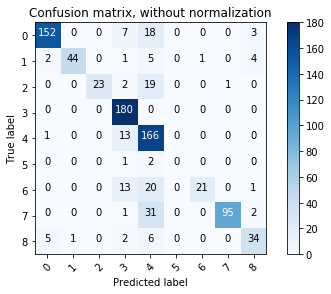

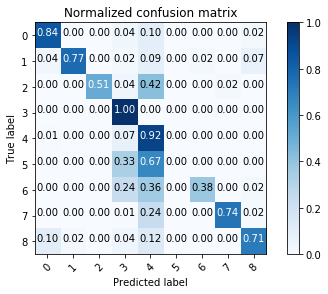

TEST CONFUSION MATRIX
Confusion matrix, without normalization
[[19  0  0  0  1  0  0  0  0]
 [ 0  1  0  2  4  0  0  0  0]
 [ 0  0  1  1  4  0  0  0  0]
 [ 0  0  0 20  0  0  0  0  0]
 [ 1  0  0  3 16  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0]
 [ 1  0  0  1  3  0  1  0  1]
 [ 0  0  0  0  8  0  0  6  1]
 [ 2  0  0  0  4  0  0  0  0]]
Normalized confusion matrix
[[0.95       0.         0.         0.         0.05       0.
  0.         0.         0.        ]
 [0.         0.14285714 0.         0.28571429 0.57142857 0.
  0.         0.         0.        ]
 [0.         0.         0.16666667 0.16666667 0.66666667 0.
  0.         0.         0.        ]
 [0.         0.         0.         1.         0.         0.
  0.         0.         0.        ]
 [0.05       0.         0.         0.15       0.8        0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         1.         0.
  0.         0.         0.        ]
 [0.14285714 0.         0.         0.14285714 0.42857143 0.
  0

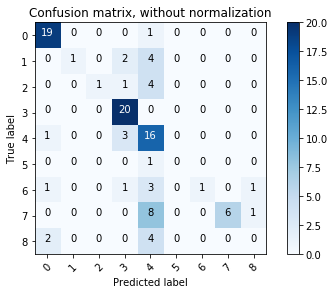

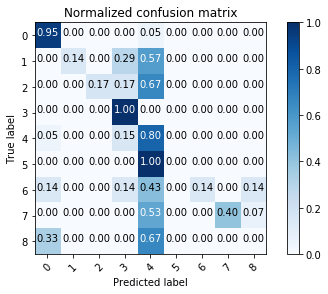

In [44]:
# draw confusion matrix
print("TRAIN CONFUSION MATRIX")
y_pred_train = model.predict(X_train_emb)
print_confusion_matrix(X_train_emb, y_train.argmax(axis=1), y_pred_train.argmax(axis=1), categories_count=9)
print("TEST CONFUSION MATRIX")
y_pred_test = model.predict(X_test_emb)
print_confusion_matrix(X_test_emb, y_test.argmax(axis=1), y_pred_test.argmax(axis=1), categories_count=9)